# Assignment 3

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Importing CIFAR10 dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [3]:
train_dataset.data.shape

(50000, 32, 32, 3)

## Normalizing, reshaping and parsing to tensor

In [22]:
data = train_dataset.data
dataN = data / np.max(data)
dataT = dataN.reshape(50000, 3, 32, 32)
dataT = torch.tensor( dataT, dtype = torch.float32)
dataT.shape

torch.Size([50000, 3, 32, 32])

## Definning the model

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc_mu = nn.Linear(512, 128)  # mean vector
        self.fc_logvar = nn.Linear(512, 128)  # log variance vector
        self.fc3 = nn.Linear(128, 512)
        self.fc4 = nn.Linear(512, 32*32*3)

    def encoder(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        h = F.relu(self.fc3(z))
        h = torch.sigmoid(self.fc4(h))
        return h.view(-1, 3, 32, 32)  # Reshape back to (batch_size, 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterization(mu, logvar)
        predicted = self.decoder(z)
        return predicted, mu, logvar


In [6]:
def loss_func(reconstructed_image, original_image, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_image, original_image, reduction = 'sum') # BCE Loss for image reconstruction
    DKL = -0.5 * torch.sum(-logvar.exp() - mu.pow(2) + 1 + logvar) # kld loss for reduccing similarities b/w distributions.
    return BCE + DKL # sum of all the losses

## Checking gpu

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [8]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
model

VAE(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3072, bias=True)
)

## Trainning

In [9]:
epochs = 41001

losses = torch.zeros(epochs)

for epoch in range(epochs):

  # Selecting a batchsize  of 32.

  random_idx = np.random.choice(dataT.shape[0], size=32)

  X = dataT[random_idx,:].to(device)
  predicted, mu, logvar = model(X)
  loss = loss_func(predicted, X, mu, logvar)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  losses[epoch] = loss.item()

  if (epoch % 1000) == 0:
      print(f' epochs : {epoch}  loss : {loss : 2.2f}')

 epochs : 0  loss :  68902.83
 epochs : 1000  loss :  61344.53
 epochs : 2000  loss :  60894.65
 epochs : 3000  loss :  57855.21
 epochs : 4000  loss :  59710.07
 epochs : 5000  loss :  59014.20
 epochs : 6000  loss :  60463.68
 epochs : 7000  loss :  58178.30
 epochs : 8000  loss :  58107.47
 epochs : 9000  loss :  59517.93
 epochs : 10000  loss :  58260.95
 epochs : 11000  loss :  57576.76
 epochs : 12000  loss :  61224.45
 epochs : 13000  loss :  61048.30
 epochs : 14000  loss :  57190.71
 epochs : 15000  loss :  56092.14
 epochs : 16000  loss :  60734.97
 epochs : 17000  loss :  59430.27
 epochs : 18000  loss :  60541.11
 epochs : 19000  loss :  58584.97
 epochs : 20000  loss :  57399.86
 epochs : 21000  loss :  58473.43
 epochs : 22000  loss :  57640.12
 epochs : 23000  loss :  57392.04
 epochs : 24000  loss :  58289.05
 epochs : 25000  loss :  59019.65
 epochs : 26000  loss :  58601.17
 epochs : 27000  loss :  60485.65
 epochs : 28000  loss :  59979.75
 epochs : 29000  loss :  59

## Evaluating the model

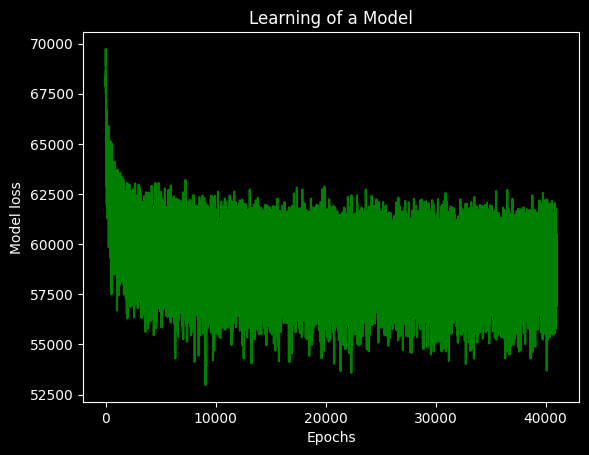

In [10]:
plt.plot(losses, color = 'g', ls = '-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Learning of a Model')
plt.show()

In [11]:
def smooth(x,k=7):
  return np.convolve(x,np.ones(k)/k,mode='same')

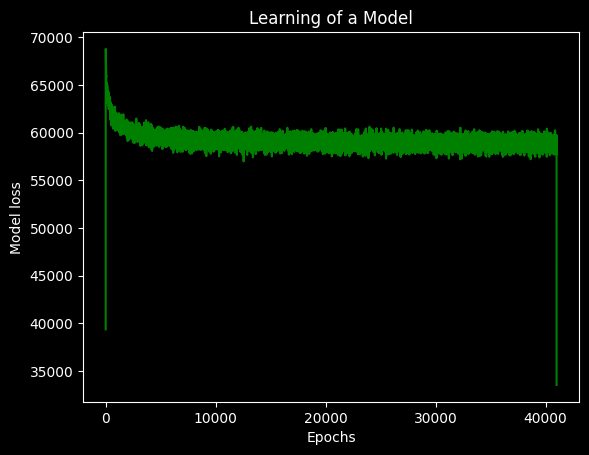

In [12]:
plt.plot(smooth(losses), color = 'g', ls = '-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Learning of a Model')
plt.show()

In [13]:
X = dataT[:7,:].to(device)  # Extracting first seven samples
ypred, mu, logvar = model(X)

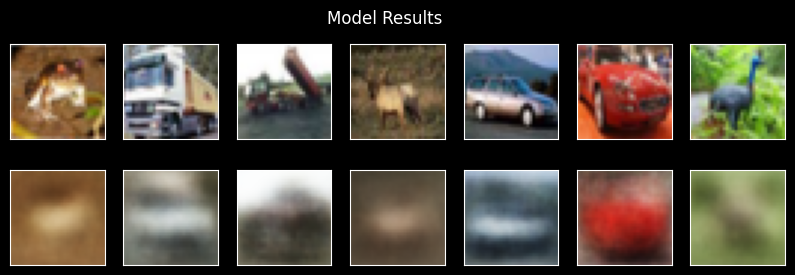

In [14]:
fig,axes = plt.subplots(2,7,figsize=(10,3))

for i in range(7):
  axes[0,i].imshow(X[i,:].view(32,32,3).detach().cpu() ,cmap='gray')
  axes[1,i].imshow(ypred[i,:].view(32,32,3).detach().cpu() ,cmap='gray')
  axes[0,i].set_xticks([]), axes[0,i].set_yticks([])
  axes[1,i].set_xticks([]), axes[1,i].set_yticks([])

plt.suptitle('Model Results')
plt.show()

## Decoding from noise

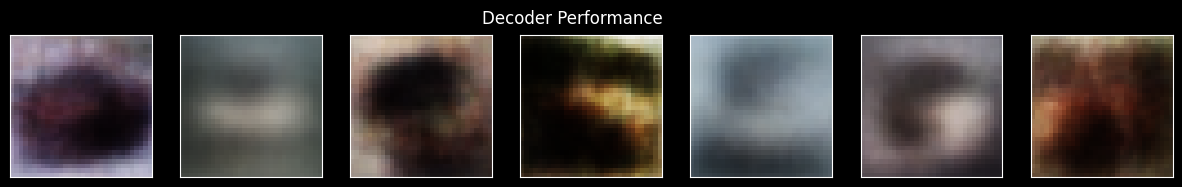

In [21]:
sample = torch.randn(7, 128)
y_pred = model.decoder(sample.to(device))

fig,axes = plt.subplots(1,7,figsize=(15,2))

for i in range(7):
  axes[i].imshow(y_pred[i,:].view(32,32,3).detach().cpu() ,cmap='gray')
  axes[i].set_xticks([]), axes[i].set_yticks([])
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.suptitle('Decoder Performance')
plt.show()